### Testing out ResNet50

In [1]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Misc
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG16, MobileNetV2, ResNet50
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
def plot_history(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

In [3]:
base_dir = 'images/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

nb_train_samples = 2000
nb_test_samples = 1000
nb_validation_samples = 1000
epochs = 5
batch_size = 32
image_size = 224

### Augmentation

In [4]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(
                rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Create the base model from the pre-trained convnets

First, we need to pick which intermediate layer of ResNet50 we will use for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate a ResNet50 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Feature extraction

We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [6]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Add a classification head

Now let's add a few layers on top of the base model:

In [7]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='sigmoid')
])

### Compile

In [8]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


These 2K trainable parameters are divided among 2 TensorFlow Variable objects, the weights and biases of the two dense layers:


In [10]:
len(model.trainable_weights)

2

### Train the model

In [11]:
epochs=10
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
125/125 [==============================] - 23s 186ms/step - loss: 0.4820 - acc: 0.7900 - val_loss: 0.6933 - val_acc: 0.5131
Epoch 2/10
125/125 [==============================] - 19s 155ms/step - loss: 0.2780 - acc: 0.9183 - val_loss: 0.7025 - val_acc: 0.4990
Epoch 3/10
125/125 [==============================] - 19s 153ms/step - loss: 0.2012 - acc: 0.9395 - val_loss: 0.7148 - val_acc: 0.5036
Epoch 4/10
125/125 [==============================] - 19s 154ms/step - loss: 0.1608 - acc: 0.9555 - val_loss: 0.7321 - val_acc: 0.4980
Epoch 5/10
125/125 [==============================] - 19s 155ms/step - loss: 0.1388 - acc: 0.9583 - val_loss: 0.7395 - val_acc: 0.5005
Epoch 6/10
125/125 [==============================] - 19s 155ms/step - loss: 0.1233 - acc: 0.9605 - val_loss: 0.7419 - val_acc: 0.5036
Epoch 7/10
125/125 [==============================] - 19s 155ms/step - loss: 0.1113 - acc: 0.9660 - val_loss: 0.7543 - val_acc: 0.5020
Epoch 8

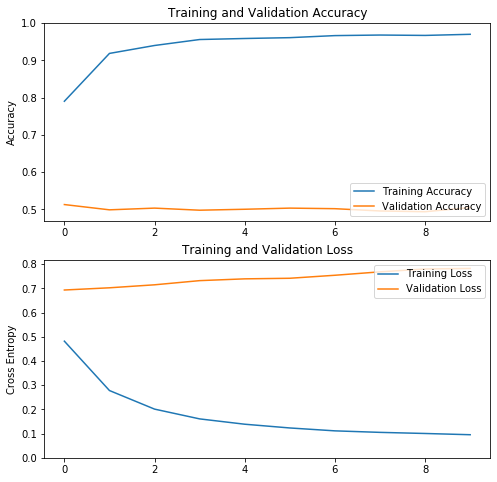

In [12]:
plot_history(history)

Validation accuracy is extremely low. It's overfitting a lot, which may be the cause of having only 2k and 1k images for trianing/validation. ResNet50 is also a more complicated architecture with over 23M parameters vs. MobileNetV2 (3.5M) but less than VGG16. One method would be to increase the number of training size and validation size.

MobileNetV2 and VGG16 did a lot better with the small sample size.

### Fine-tuning (Part 2)

In our feature extraction experiment, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

#### Note

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the

### Un-freeze the top layers of the model

All we need to do is unfreeze the base_model, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [23]:
base_model.layers

In [39]:
# Fine tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the model

Compile the model using a much-lower training rate since we are training specific layers.

In [40]:
model.compile(optimizer = RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
len(model.trainable_weights)

2

### Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [43]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
125/125 [==============================] - 21s 171ms/step - loss: 0.0905 - acc: 0.9688 - val_loss: 0.7951 - val_acc: 0.4985
Epoch 2/10
125/125 [==============================] - 19s 153ms/step - loss: 0.0870 - acc: 0.9715 - val_loss: 0.7915 - val_acc: 0.5015
Epoch 3/10
125/125 [==============================] - 19s 153ms/step - loss: 0.0872 - acc: 0.9700 - val_loss: 0.7964 - val_acc: 0.4985
Epoch 4/10
125/125 [==============================] - 19s 154ms/step - loss: 0.0883 - acc: 0.9718 - val_loss: 0.7914 - val_acc: 0.5010
Epoch 5/10
125/125 [==============================] - 19s 154ms/step - loss: 0.0810 - acc: 0.9740 - val_loss: 0.8032 - val_acc: 0.4975
Epoch 6/10
125/125 [==============================] - 20s 159ms/step - loss: 0.0855 - acc: 0.9742 - val_loss: 0.7961 - val_acc: 0.5030
Epoch 7/10
125/125 [==============================] - 20s 159ms/step - loss: 0.0876 - acc: 0.9690 - val_loss: 0.8009 - val_acc: 0.4990
Epoch 8/10
125/125 [==============================] - 2

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the ResNet50 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

Note: the training dataset is fairly small, and is similar to the original datasets that MobileNet V2 was trained on, so fine-tuning may result in overfitting.

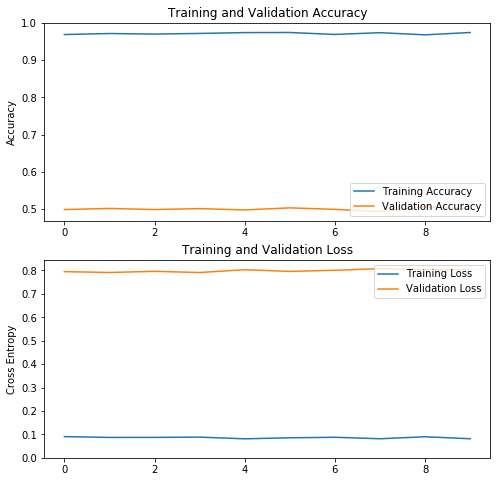

In [44]:
plot_history(history_fine)

--------

### Check this [Kaggle Notebook](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50) for Predictions

### Check out this question on ResNet50 training [here](https://github.com/keras-team/keras/issues/12317)